In [1]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

'[' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
#hide
from fastbook import *

In [3]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"pytorch version: {torch.__version__}")

Using device: cuda
pytorch version: 2.4.0+cu124


# Image Classification

## From Dogs and Cats to Pet Breeds

In [4]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)

In [5]:
Path.BASE_PATH = path

In [6]:
# Check what is downloaded
path.ls()

(#2) [Path('annotations'),Path('images')]

In [10]:
# Check the kind of images downloaded
(path/"images").ls()

(#7393) [Path('images/Abyssinian_1.jpg'),Path('images/Abyssinian_10.jpg'),Path('images/Abyssinian_100.jpg'),Path('images/Abyssinian_100.mat'),Path('images/Abyssinian_101.jpg'),Path('images/Abyssinian_101.mat'),Path('images/Abyssinian_102.jpg'),Path('images/Abyssinian_102.mat'),Path('images/Abyssinian_103.jpg'),Path('images/Abyssinian_104.jpg')...]

In [11]:
fname = (path/"images").ls()[0]

In [12]:
# Finding files with same breed name using regex
re.findall(r'(.+)_\d+.jpg$', fname.name)

['Abyssinian']

In [14]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders(path/"images")

## Presizing

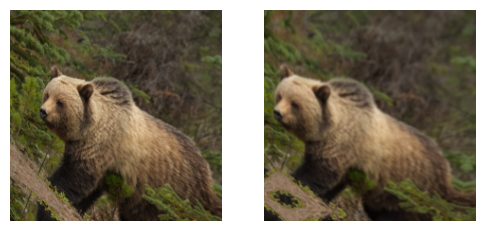

In [15]:
dblock1 = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                   get_y=parent_label,
                   item_tfms=Resize(460))

# Place an image in the 'images/grizzly.jpg' subfolder where this notebook is located before running this
dls1 = dblock1.dataloaders([(Path.cwd()/'downloaded_imgs'/'grizzly.jpg')]*100, bs=8)
dls1.train.get_idxs = lambda: Inf.ones # To demoonstrate using the same image multiple times
x,y = dls1.valid.one_batch() # Retrieve one batch of data
_,axs = subplots(1, 2)

x1 = TensorImage(x.clone())
x1 = x1.affine_coord(sz=224) # Apply the affine transform and resize img to 224 pixels
x1 = x1.rotate(draw=30, p=1.) # Rotates the image tensor by 30 degrees with a probability of 1
x1 = x1.zoom(draw=1.2, p=1.) # Zooms into the image tensor by a factor of 1.2 with a probability of 1
x1 = x1.warp(draw_x=-0.2, draw_y=0.2, p=1.) # Applies a warp transformation to the image tensor, shifting it by -0.2 along the x-axis and 0.2 along the y-axis with a probability of 1

# Method to combine all transformations into a single pipeline
tfms = setup_aug_tfms([Rotate(draw=30, p=1, size=224), Zoom(draw=1.2, p=1., size=224),
                       Warp(draw_x=-0.2, draw_y=0.2, p=1., size=224)])
x = Pipeline(tfms)(x)
#x.affine_coord(coord_tfm=coord_tfm, sz=size, mode=mode, pad_mode=pad_mode)
TensorImage(x[0]).show(ctx=axs[0])
TensorImage(x1[0]).show(ctx=axs[1]);

### Checking and Debugging a DataBlock

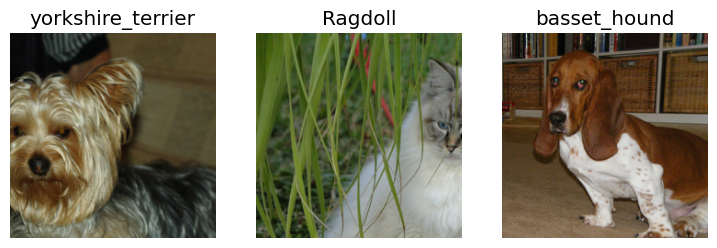

In [17]:
dls.show_batch(nrows=1, ncols=3)

In [21]:
pets1 = DataBlock(blocks=(ImageBlock, CategoryBlock),
         get_items=get_image_files, 
         splitter=RandomSplitter(seed=42),
         get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
         item_tfms=Resize(256))
pets1.summary(path/"images")

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      C:\Users\jared\.fastai\data\oxford-iiit-pet\images\saint_bernard_138.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=500x375
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      C:\Users\jared\.fastai\data\oxford-iiit-pet\images\saint_bernard_138.jpg
    applying partial gives
      saint_bernard
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(30)

Final sample: (PILImage mode=RGB size=500x375, TensorCategory(30))


Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na':

In [22]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,1.497193,0.346175,0.111637,00:45


epoch,train_loss,valid_loss,error_rate,time
0,0.504973,0.326272,0.108931,00:41
1,0.333458,0.204732,0.064953,00:41


## Cross-Entropy Loss

### Viewing Activations and Labels

In [23]:
x,y = dls.one_batch()

In [24]:
y

TensorCategory([ 8, 35, 18, 11,  2,  5,  4, 32,  9, 18,  2, 27, 17, 33, 15,  0, 33, 31, 15,  3, 24, 33,  0, 33,  7, 19,  3, 16, 31, 12, 10, 33, 11,  2, 27, 26, 20, 30, 24,  6, 36, 22, 30,  2, 26,  3,
                13, 10,  2,  6, 14,  6, 35, 13,  2,  1,  1, 14,  1, 17, 14,  5,  2, 14], device='cuda:0')

In [25]:
preds,_ = learn.get_preds(dl=[(x,y)])
preds[0]

tensor([4.2399e-02, 1.5978e-03, 3.4628e-04, 1.0212e-02, 2.2307e-02, 7.3189e-03, 2.9232e-03, 7.9502e-03, 8.9406e-01, 5.2941e-04, 7.9585e-04, 1.1407e-03, 3.0191e-04, 5.5068e-04, 1.0838e-04, 2.3345e-05,
        6.2418e-05, 2.8840e-04, 1.3764e-04, 1.1449e-04, 1.2807e-05, 1.9774e-04, 3.0722e-04, 1.0274e-03, 1.1746e-04, 3.5338e-05, 4.7774e-04, 5.7852e-05, 1.7634e-03, 5.2749e-04, 1.6321e-04, 8.1707e-04,
        3.8779e-05, 1.0600e-04, 2.4400e-05, 4.8871e-05, 1.1142e-03])

In [26]:
len(preds[0]),preds[0].sum()

(37, tensor(1.0000))

### Softmax

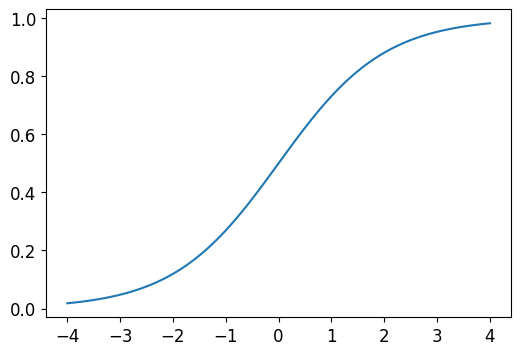

In [27]:
plot_function(torch.sigmoid, min=-4,max=4)

In [28]:
#hide
torch.random.manual_seed(42);

In [29]:
acts = torch.randn((6,2))*2
acts

tensor([[ 0.6734,  0.2576],
        [ 0.4689,  0.4607],
        [-2.2457, -0.3727],
        [ 4.4164, -1.2760],
        [ 0.9233,  0.5347],
        [ 1.0698,  1.6187]])

In [30]:
acts.sigmoid()

tensor([[0.6623, 0.5641],
        [0.6151, 0.6132],
        [0.0957, 0.4079],
        [0.9881, 0.2182],
        [0.7157, 0.6306],
        [0.7446, 0.8346]])

In [31]:
(acts[:,0]-acts[:,1]).sigmoid()

tensor([0.6025, 0.5021, 0.1332, 0.9966, 0.5959, 0.3661])

In [32]:
sm_acts = torch.softmax(acts, dim=1)
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

### Log Likelihood

In [33]:
targ = tensor([0,1,0,1,1,0])

In [34]:
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

In [35]:
idx = range(6)
sm_acts[idx, targ]

tensor([0.6025, 0.4979, 0.1332, 0.0034, 0.4041, 0.3661])

In [44]:
# check version of pandas
import pandas as pd
print(f"pandas version: {pd.__version__}")

pandas version: 2.2.2


In [48]:
from IPython.display import HTML
df = pd.DataFrame(sm_acts, columns=["3","7"])
df['targ'] = targ
df['idx'] = idx
df['result'] = sm_acts[range(6), targ]
t= df.style.hide(axis="index")

#To have html code compatible with our script
html = t._repr_html_().split('</style>')[1]
html = re.sub(r'<table id="([^"]+)"\s*>', r'<table >', html)
display(HTML(html))

3,7,targ,idx,result
0.602469,0.397531,0,0,0.602469
0.502065,0.497935,1,1,0.497935
0.133188,0.866811,0,2,0.133188
0.996640,0.003360,1,3,0.003360
0.595949,0.404051,1,4,0.404051
0.366118,0.633882,0,5,0.366118


In [49]:
-sm_acts[idx, targ]

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

In [50]:
F.nll_loss(sm_acts, targ, reduction='none')

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

#### Taking the Log

Recall that cross entropy loss may involve the multiplication of many numbers.  Multiplying lots of negative numbers together can cause problems like [numerical underflow](https://en.wikipedia.org/wiki/Arithmetic_underflow) in computers.  Therefore, we want to transform these probabilities to larger values so we can perform mathematical operations on them.  There is a mathematical function that does exactly this: the *logarithm* (available as `torch.log`). It is not defined for numbers less than 0, and looks like this between 0 and 1:

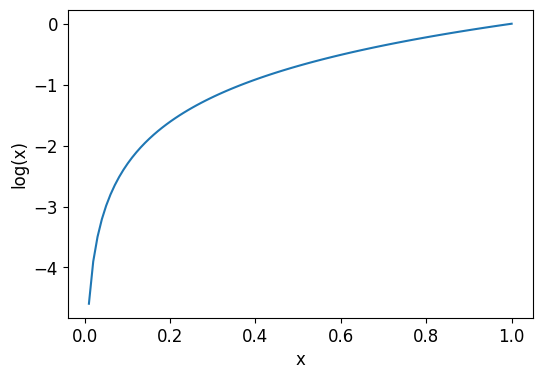

In [51]:
plot_function(torch.log, min=0,max=1, ty='log(x)', tx='x')

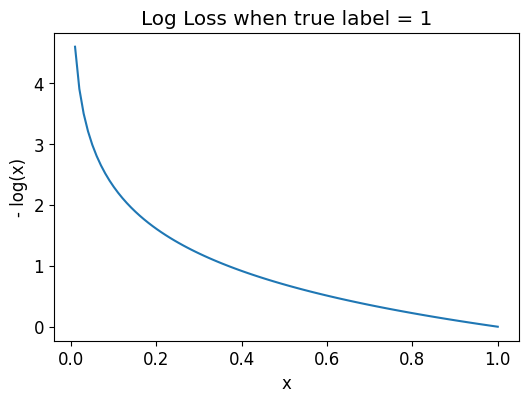

In [52]:
plot_function(lambda x: -1*torch.log(x), min=0,max=1, tx='x', ty='- log(x)', title = 'Log Loss when true label = 1')

In [54]:
from IPython.display import HTML
df['loss'] = -torch.log(tensor(df['result']))
t = df.style.hide(axis="index")
#To have html code compatible with our script
html = t._repr_html_().split('</style>')[1]
html = re.sub(r'<table id="([^"]+)"\s*>', r'<table >', html)
display(HTML(html))

3,7,targ,idx,result,loss
0.602469,0.397531,0,0,0.602469,0.506720
0.502065,0.497935,1,1,0.497935,0.697285
0.133188,0.866811,0,2,0.133188,2.015990
0.996640,0.003360,1,3,0.003360,5.695763
0.595949,0.404051,1,4,0.404051,0.906213
0.366118,0.633882,0,5,0.366118,1.004798


### Negative Log Likelihood

In [55]:
loss_func = nn.CrossEntropyLoss()

In [56]:
loss_func(acts, targ)

tensor(1.8045)

In [57]:
F.cross_entropy(acts, targ)

tensor(1.8045)

In [58]:
nn.CrossEntropyLoss(reduction='none')(acts, targ)

tensor([0.5067, 0.6973, 2.0160, 5.6958, 0.9062, 1.0048])

## Model Interpretation

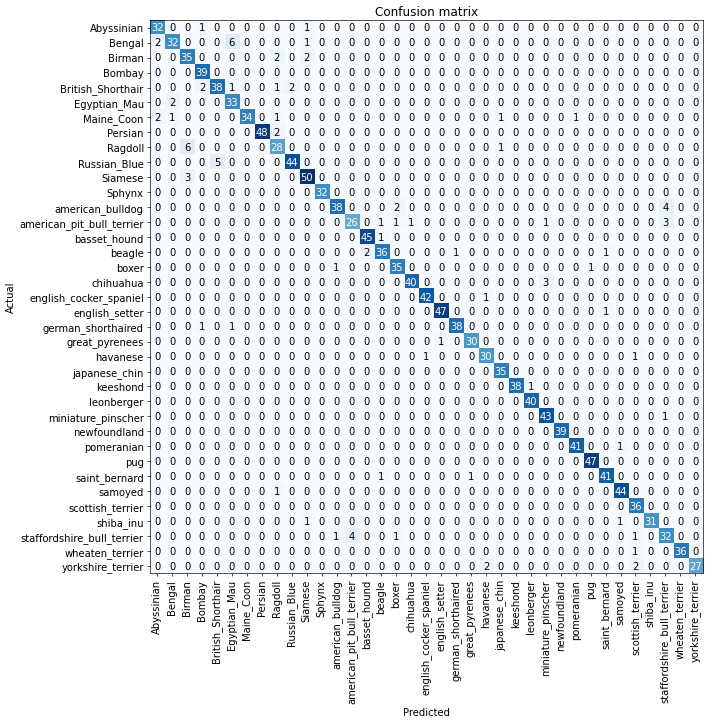

In [59]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [60]:
interp.most_confused(min_val=5)

[('Bengal', 'Egyptian_Mau', 6),
 ('Ragdoll', 'Birman', 6),
 ('Russian_Blue', 'British_Shorthair', 5)]

## Improving Our Model

### The Learning Rate Finder

In [61]:
# Example without lr_find
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1, base_lr=0.1)

epoch,train_loss,valid_loss,error_rate,time
0,2.847111,5.555823,0.536536,00:38


epoch,train_loss,valid_loss,error_rate,time
0,4.153726,2.842630,0.814614,00:38


c:\Users\jared\Documents\fastai_repo\fastbook\fastai_venv\Lib\site-packages\fastai\learner.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_

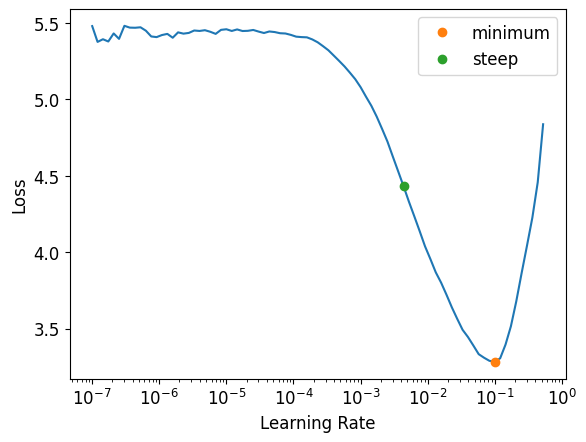

In [62]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
lr_min,lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

In [63]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 1.00e-02, steepest point: 4.37e-03


In [64]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=4e-3) # Value based on lr_find

epoch,train_loss,valid_loss,error_rate,time
0,1.223700,0.324848,0.103518,00:37


epoch,train_loss,valid_loss,error_rate,time
0,0.591603,0.489759,0.135995,00:38
1,0.361703,0.232819,0.075101,00:38


### Unfreezing and Transfer Learning

In [65]:
learn.fine_tune??

Signature:
learn.fine_tune(
    epochs,
    base_lr=0.002,
    freeze_epochs=1,
    lr_mult=100,
    pct_start=0.3,
    div=5.0,
    *,
    lr_max=None,
    div_final=100000.0,
    wd=None,
    moms=None,
    cbs=None,
    reset_opt=False,
    start_epoch=0,
)
Source:   
@patch
@delegates(Learner.fit_one_cycle)
def fine_tune(self:Learner, epochs, base_lr=2e-3, freeze_epochs=1, lr_mult=100,
              pct_start=0.3, div=5.0, **kwargs):
    "Fine tune with `Learner.freeze` for `freeze_epochs`, then with `Learner.unfreeze` for `epochs`, using discriminative LR."
    self.freeze()
    self.fit_one_cycle(freeze_epochs, slice(base_lr), pct_start=0.99, **kwargs)
    base_lr /= 2
    self.unfreeze()
    self.fit_one_cycle(epochs, slice(base_lr/lr_mult, base_lr), pct_start=pct_start, div=div, **kwargs)
File:      c:\users\jared\documents\fastai_repo\fastbook\fastai_venv\lib\site-packages\fastai\callback\schedule.py
Type:      method

In [66]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.127340,0.389543,0.125169,00:35
1,0.526534,0.245070,0.087957,00:37
2,0.332190,0.207421,0.068336,00:37


In [67]:
learn.unfreeze()

c:\Users\jared\Documents\fastai_repo\fastbook\fastai_venv\Lib\site-packages\fastai\learner.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_

SuggestedLRs(valley=4.365158383734524e-05)

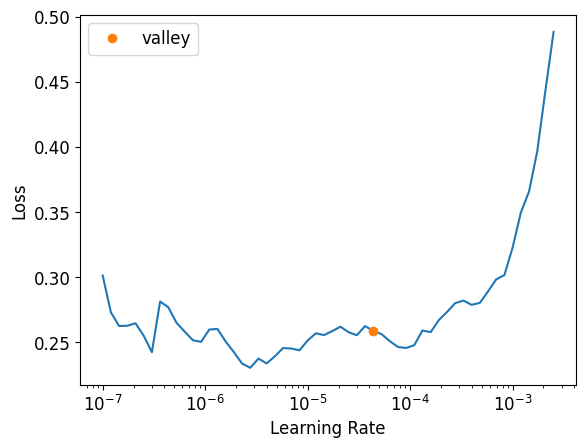

In [68]:
learn.lr_find()

In [69]:
learn.fit_one_cycle(6, lr_max=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.254742,0.206155,0.066982,00:38
1,0.236233,0.201491,0.061570,00:36
2,0.220378,0.195929,0.062923,00:38
3,0.206278,0.190210,0.061570,00:39
4,0.193279,0.189447,0.060217,00:39
5,0.170892,0.190818,0.064276,00:39


### Discriminative Learning Rates

In [70]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.147197,0.351401,0.117727,00:38
1,0.541031,0.262927,0.081867,00:38
2,0.319915,0.227635,0.073072,00:38


epoch,train_loss,valid_loss,error_rate,time
0,0.252198,0.222970,0.073748,00:39
1,0.244911,0.212983,0.073748,00:38
2,0.223806,0.206204,0.071042,00:36
3,0.217055,0.195694,0.063599,00:35
4,0.194865,0.190181,0.060893,00:36
5,0.170694,0.190192,0.059540,00:36
6,0.144211,0.197061,0.066982,00:55
7,0.147740,0.188812,0.064953,00:37
8,0.142251,0.183503,0.062923,00:36
9,0.130311,0.181846,0.059540,00:38


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

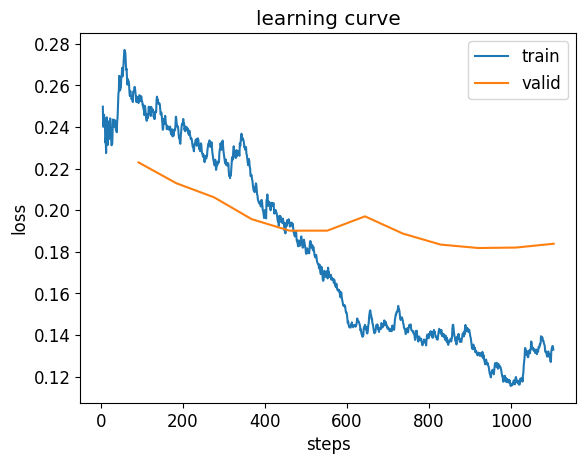

In [71]:
learn.recorder.plot_loss()

### Selecting the Number of Epochs

### Deeper Architectures

In [72]:
from fastai.callback.fp16 import *
learn = vision_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fine_tune(6, freeze_epochs=3)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\jared/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 35.0MB/s]
c:\Users\jared\Documents\fastai_repo\fastbook\fastai_venv\Lib\site-packages\fastai\callback\fp16.py:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
c:\Users\jared\Documents\fastai_repo\fastbook\fastai_venv\Lib\site-packages\fastai\callback\fp16.py:45: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,error_rate,time
0,2.141448,0.496404,0.149526,00:40
1,0.837097,0.314751,0.094046,00:40
2,0.539291,0.329836,0.104195,00:39


epoch,train_loss,valid_loss,error_rate,time
0,0.273824,0.229088,0.071042,00:41
1,0.261828,0.231599,0.066306,00:40
2,0.192994,0.206676,0.066306,00:40
3,0.123758,0.198341,0.057510,00:41
4,0.091784,0.173075,0.050068,00:41
5,0.065938,0.171628,0.052774,00:41
